# Usable UMIs Amount Estimation
To avoid sequencing and PCR errors, we use only UMIs with multiple duplicate reads. To determine a required sequencing depth (number of reads per cell), we would like to model the relationship between sequencing depth and number of UMIs present in given number of duplicates.

We use dataset obtained from mouse kidneys, sequenced by 10x sequencing.


In [1]:
import pysam
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin
from tqdm import tqdm
from collections import Counter, OrderedDict
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy import stats
import pandas as pd
from itertools import chain

In [2]:
bam_files_data_folder = Path('/cellfile/datapublic/jkoubele/DR_dataset/AL4_old', desc='Processing .bam files')

@dataclass
class CellStatistics(DataClassJsonMixin):
    barcode: str
    num_reads: int
    duplicate_counter: dict[int, int]
        
@dataclass
class Dataset(DataClassJsonMixin):
    cells: list[CellStatistics]
    

run_processing_of_bam_files = False # change to True to re-run the .bam files processing
if run_processing_of_bam_files:
    cells: list[CellStatistics] = []
    for file_path in tqdm(bam_files_data_folder.iterdir()):
        if file_path.suffix != '.bam':
            continue
        samfile = pysam.AlignmentFile(file_path, "rb")
        reads = [read for read in samfile if read.mapq >= 255 and 
                 read.has_tag('UB') and
                 read.get_tag('UB') != '-' and
                 read.reference_name != 'chrM']
        umi_counter = Counter([read.get_tag('UB') for read in reads])
        cells.append(CellStatistics(barcode=file_path.stem,
                                   num_reads=len(reads),
                                    duplicate_counter = dict(Counter(umi_counter.values()))
                                   ))    

    with open(f'./duplicate_counters_{bam_files_data_folder.stem}.json', 'w') as file_out:
        file_out.write(Dataset(cells=cells).to_json())
    
        

The median sequencing depth was 51k reads, and median number of UMIs was 22k.

We plot the histograms of reads per cell and also UMIs per cell:

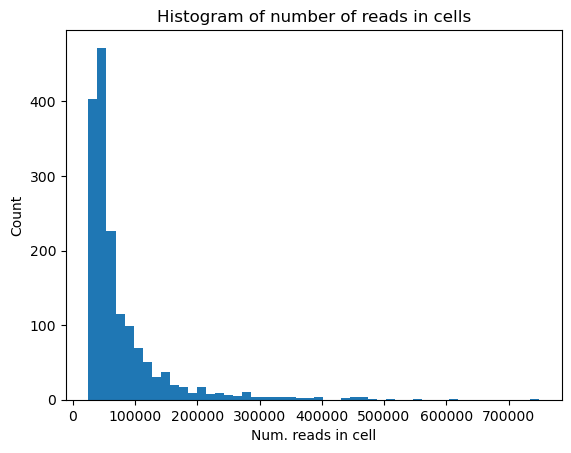

Descriptive statistics:
 count      1643.000000
mean      77017.091905
std       69638.623491
min       25043.000000
25%       39670.000000
50%       51759.000000
75%       84637.500000
max      749563.000000
dtype: float64


In [3]:
with open('./duplicate_counters_AL4_old.json') as input_file:
    dataset = Dataset.from_json(input_file.read())
    cells = dataset.cells

num_reads = [cell.num_reads for cell in cells]

plt.hist(num_reads, bins=50)
plt.xlabel('Num. reads in cell')
plt.ylabel('Count')
plt.title('Histogram of number of reads in cells')
plt.show()

print("Descriptive statistics:\n", pd.Series(num_reads).describe())

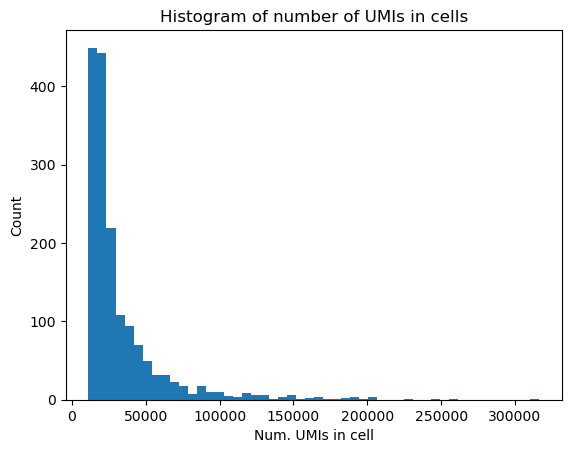

Descriptive statistics:
 count      1643.000000
mean      33016.648813
std       30093.251918
min       11162.000000
25%       16882.500000
50%       22057.000000
75%       36387.000000
max      316485.000000
dtype: float64


In [4]:
num_umis = [sum(cell.duplicate_counter.values()) for cell in cells]

plt.hist(num_umis, bins=50)
plt.xlabel('Num. UMIs in cell')
plt.ylabel('Count')
plt.title('Histogram of number of UMIs in cells')
plt.show()

print("Descriptive statistics:\n", pd.Series(num_umis).describe())

Although cells somehow vary in the number of reads, the fraction of UMIs with a given number of duplicates is quite stable across the cells. E.g, most cells have about 40% of UMIs that have only 1 read, 25% of UMIs with 2 reads, etc.

This suggests that the differences in number of reads is driven primarily by cell size / mRNA content, and not by different capturing efficiency.

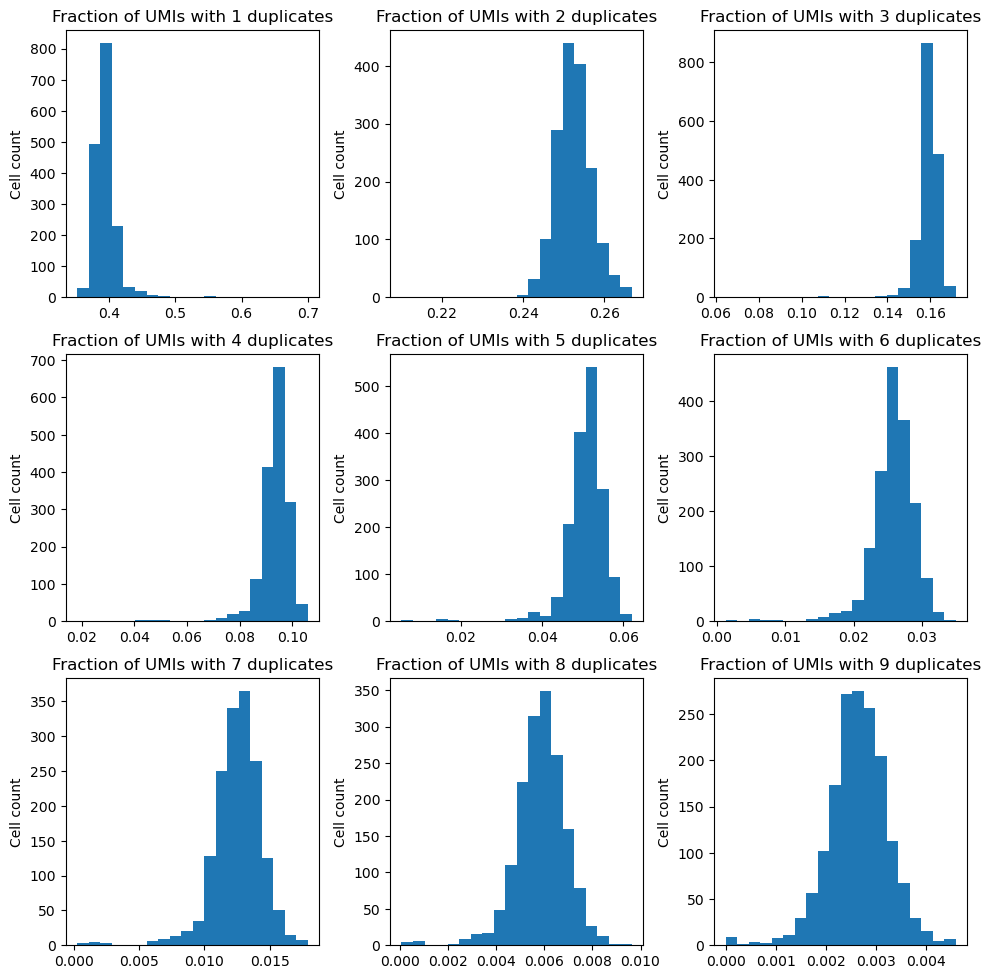

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
plt.tight_layout(pad=2)
for duplicate_number in range(1,10):    
    plt.subplot(3,3,duplicate_number)    
    plt.hist([(cell.duplicate_counter[duplicate_number] if duplicate_number in cell.duplicate_counter else 0)
              / sum(cell.duplicate_counter.values())
              for cell in cells], bins=20)    
    plt.title(f'Fraction of UMIs with {duplicate_number} duplicates')
    plt.ylabel('Cell count')    
plt.show()

We may therefore aggregate the reads from all cells together, to get a distribution of UMI duplicates in an average or median cell. 

As cells contain only negligible amount of UMIs that have more than 15 duplicates, we will omit them to simplify the analysis (and make plotting easier).

Average number of UMIs with more than 15 duplicates: 0.7395009129640913
Number of reads in average cell: 76999.92574558737
Number of UMIs in average cell: 33015.909312233714
Number of reads in median cell: 51873.0
Number of UMIs in median cell: 22102.0


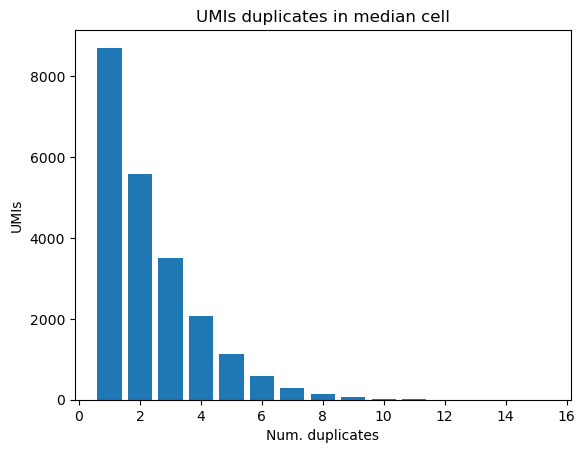

In [6]:
duplicate_numbers = set(chain.from_iterable([cell.duplicate_counter.keys() for cell in cells]))
average_cell_duplicate_counter = {duplicate_number:
                                  sum([cell.duplicate_counter[duplicate_number] if duplicate_number in cell.duplicate_counter else 0 for cell in cells]) / len(cells)
                                 for duplicate_number in duplicate_numbers}
print(f"Average number of UMIs with more than 15 duplicates: {sum([value for key, value in average_cell_duplicate_counter.items() if key > 15])}")
average_cell_duplicate_counter = {key: value for key, value in average_cell_duplicate_counter.items() if key <=15}
average_cell_duplicate_counter = OrderedDict({key: average_cell_duplicate_counter[key] for key in sorted(average_cell_duplicate_counter.keys())})
print(f"Number of reads in average cell: {sum([key * value for key, value in average_cell_duplicate_counter.items()])}")
print(f"Number of UMIs in average cell: {sum(average_cell_duplicate_counter.values())}")

median_cell_duplicate_counter = OrderedDict({duplicate_number:
                                             np.median([cell.duplicate_counter[duplicate_number] if duplicate_number in cell.duplicate_counter else 0 for cell in cells])
                                             for duplicate_number in range(1,16)})

print(f"Number of reads in median cell: {sum([key * value for key, value in median_cell_duplicate_counter.items()])}")
print(f"Number of UMIs in median cell: {sum(median_cell_duplicate_counter.values())}")


plt.bar(median_cell_duplicate_counter.keys(), height=median_cell_duplicate_counter.values())
plt.title('UMIs duplicates in median cell')
plt.ylabel('UMIs')
plt.xlabel('Num. duplicates')
plt.show()